### Chapt 7. Ensemble Learning and Random Forest

#### 7.1 Voting Classifiers 투표 기반 분류기

In [23]:
## Basic Setting

# Python >=3.5
import sys
assert sys.version_info >= (3,5)

# Scikit-Learn >=0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# common module import
import numpy as np
import os

# notebook results consistency
np.random.seed(42)

# Clear Graphic
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# save pic
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout = True, fig_extension = "png", resolution =300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()   ## 주의! plt.tight_layout() => .layout()으로 실수하지 말것 
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [24]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0) / np.arange(1, 10001).reshape(-1, 1)

그림 저장: law_of_large_numbers_plot


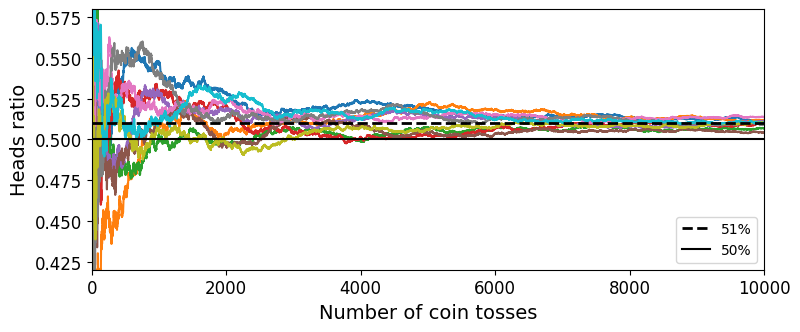

In [25]:
# Law of Large Numbers

plt.figure(figsize = (8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0,10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0,10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [27]:
# moons dataset

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')  # voting hard


In [32]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [34]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [36]:
# Indirect Voting
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability = True, random_state = 42)

voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft') # voting soft
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [37]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


#### 7.2 Bagging and Pasting 배깅과 페이스팅
#### 7.2.1 Bagging and Pasting in Scikit-Learn

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, random_state=42)  ## Pasting: boostrap=False
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [41]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [45]:
# a single decision-tree and 500 decision tree with Bagging

from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf, X, y, axes = [-1.5, 2.45, -1, 1.5], alpha = 0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha = alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha = alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


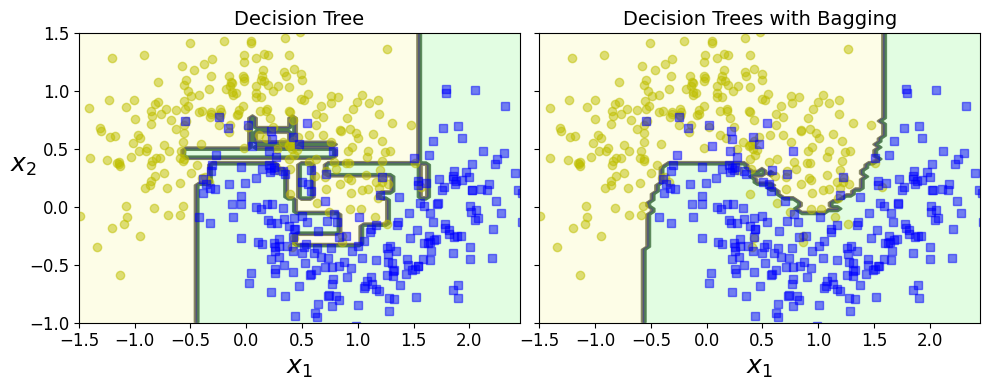

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

#### 7.2.2  Out-of_Bag Evaluation  obb 평가

In [48]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(), n_estimators=500, bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [49]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [50]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

#### 7.3 Random Patches and Random Subspaces 

#### 7.4 Random Forests

In [52]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, random_state = 42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test) # RandomForest is similar to Decision Tree with Bagging

In [53]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
n_estimators=500, random_state=42)

In [54]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [55]:
np.sum(y_pred == y_pred_rf) / len(y_pred) # Prediction is almost the same

1.0

#### 7.4.1 Extra-Trees

#### 7.4.2 Feature Importance

In [56]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [58]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

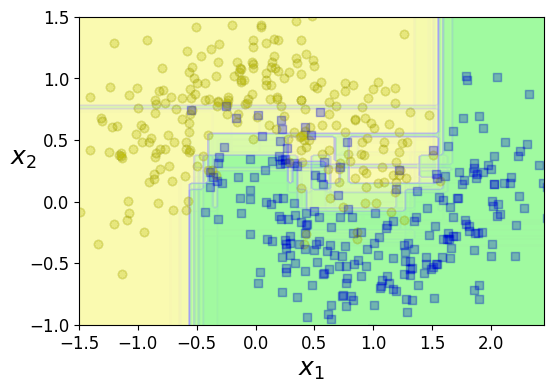

In [62]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

In [66]:
# 랜덤포레스트 분류기에서 얻은 MNIST 픽셀 중요도

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [67]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [68]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


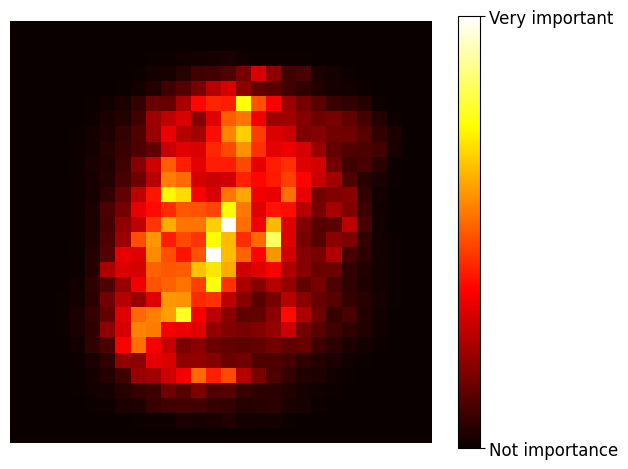

In [70]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not importance', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

#### 7.5 Boosting
#### 7.5.1 AdaBoost 에이다부스트

In [72]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=200, 
algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

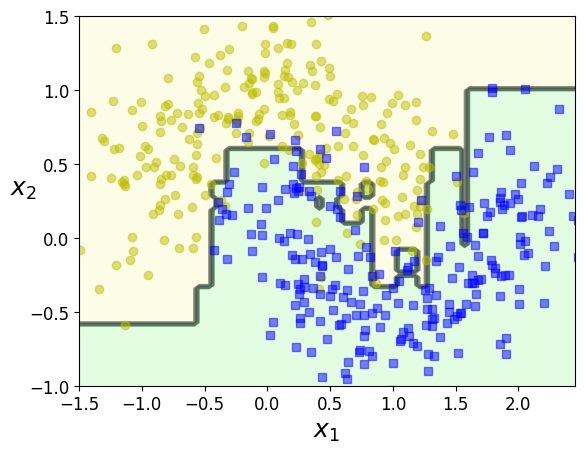

In [73]:
plot_decision_boundary(ada_clf, X, y)

그림 저장: boosting_plot


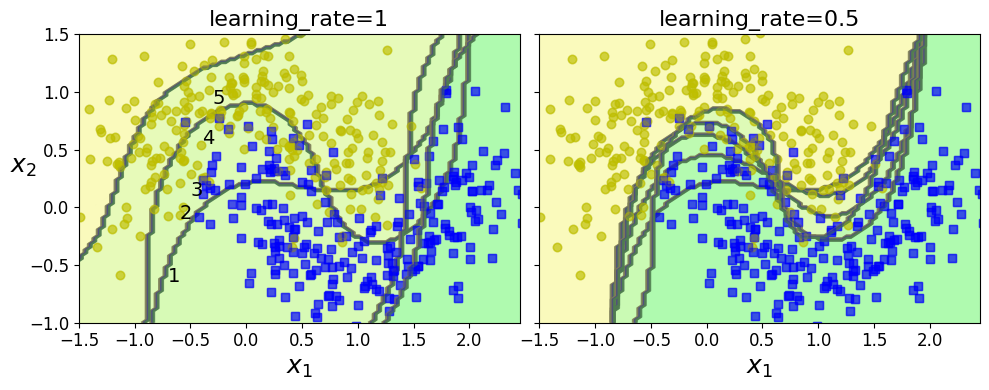

In [75]:
# 연속된 예측기의 결정 경계

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0,1), (1, 0.5)):
    sample_weights = np.ones(m)/m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights*m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate*np.log((1-r)/r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate={}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5, 0.10, "3", fontsize=14)
        plt.text(-0.4, 0.55, "4", fontsize=14)
        plt.text(-0.3, 0.90, "5", fontsize=14)
    else:
        plt.ylabel("")
        
save_fig("boosting_plot")
plt.show()

#### 7.5.2 Gradient Boosting 그레이디언트 부스팅

In [76]:
# 이차식 데이터셋

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05*np.random.randn(100)

In [78]:
# 결정트리 회귀 모델 훈련

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [84]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [102]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [103]:
X_new = np.array([[0.8]])

In [104]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [105]:
y_pred

array([0.75026781])

In [110]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):   ## "b"하면 데이터가 선으로 나타남. '.'반드시 찍을것
    x1=np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1,1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    

그림 저장: gradient_boosting_plot


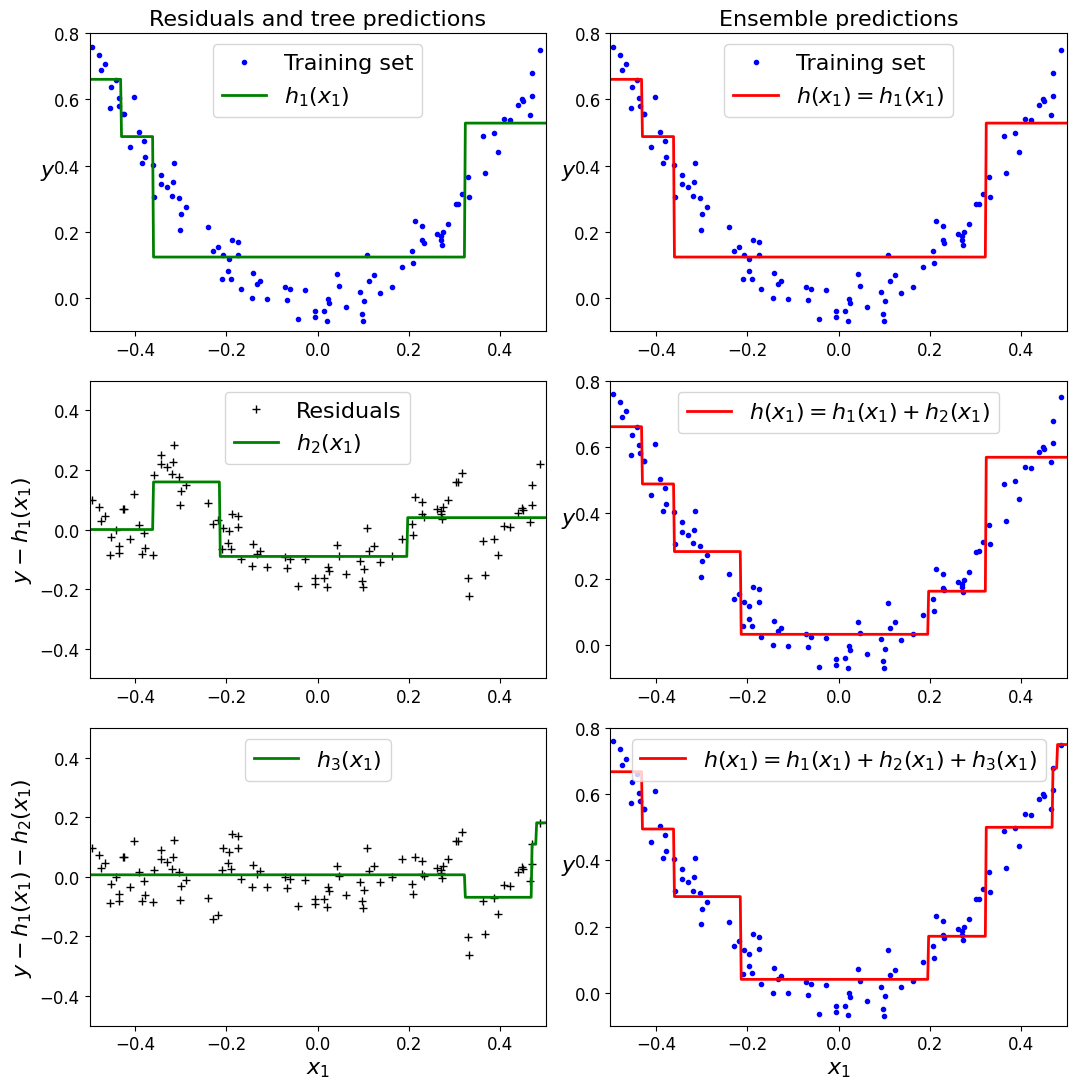

In [111]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [113]:
# 예측기가 부족한 경우, 너무 많은 경우 GBRT 앙상블 Gradient Boosted Regression Tree (GBRT)

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate = 1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [114]:

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate = 0.1, random_state=42)
gbrt_slow.fit(X,y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

그림 저장: gbrt_learning_rate_plot


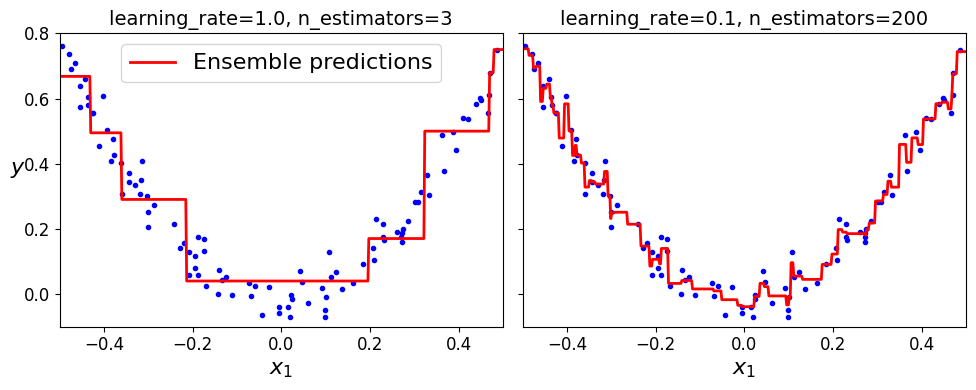

In [118]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

In [120]:
# 조기종료를 사용한 그래디언트 부스팅

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators = bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

그림 저장: early_stopping_gbrt_plot


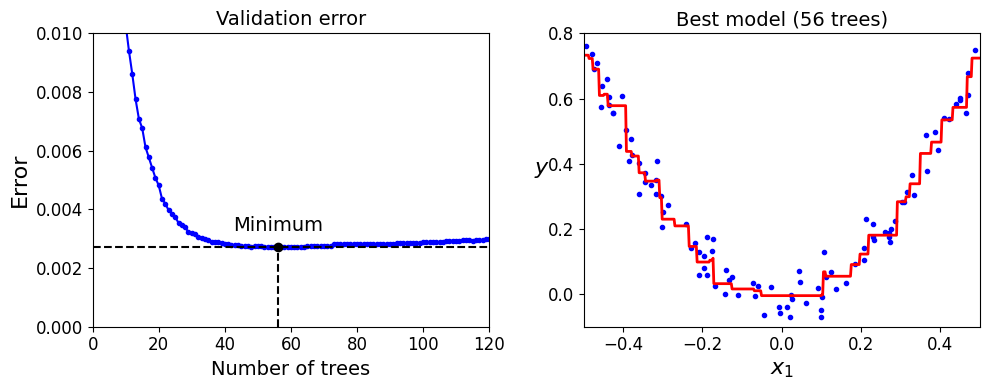

In [122]:
# 조기 종료를 사요앟여 트리 수 튜닝

min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors)+1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [124]:
# 어느 정도 유예를 갖는 조기 종료 (5 에포크 동안 향상되지 않을 때만 훈련 중지)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else: 
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [125]:
print(gbrt.n_estimators)

61


In [126]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


In [135]:
pip install xgboost

     -------------------------------------- 125.4/125.4 MB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [136]:
# XGBoost: Extreme gradient boosting, 속도, 확장성, 이식성

try:
    import xgboost
except ImportError as ex:
    print("Error: xgboost libaray is not installed")
    xgboost = None


In [138]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

Validation MSE: 0.004000408205406276


In [139]:
if xgboost is not None:
    xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


C:\Python\Venv\Py37_ML\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


In [140]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

21 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [141]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

14.4 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### 7.6 Stacking

### 연습문제

In [ ]:
## 8. MNIST 데이터, 훈련-검증-테스트 세트로 나누기
## 램덤 포르세트 분류
## 데스트라 트리 분류
## SVM 분류 훈련
## 검증세트에서 개개의 분류기 보다 더 높은 성능을 내도록 간접 또는 직접 투표 방법 사용해 앙상블로 연결
## 앙상블 얻고나면 테스트 세트로 확인, 성능 비교

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
mnist.data, mnist.target, test_size = 10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
X_train_val, y_train_val, test_size = 10000, random_state=42)

In [145]:
# 분류기 훈련

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [149]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [148]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [150]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9617]

In [151]:
# SVM 성능 떨어짐. 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 유지
# 투표 분류기를 사용하는 앙상블로 연결

from sklearn.ensemble import VotingClassifier

In [152]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [161]:
voting_clf = VotingClassifier(named_estimators)

In [162]:
voting_clf.fit(X_val, y_val)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [163]:
voting_clf.score(X_val, y_val)

0.9996

In [164]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]   ## NOTE: estimators_ '-'

[1.0, 1.0, 0.8884, 0.9952]

In [165]:
# SVM 모델 제거하고 성능이 향상되는지 확인
# set_params()   None 지정해주면 특정 예측기 제외

voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [169]:
voting_clf.estimators # 예측기 목록은 업데이트 됨

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [170]:
voting_clf.estimators_ # 훈련된 예측기 목록은 업데이트 안됨

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [171]:
del voting_clf.estimators_[2] # 훈련된 예측기 목록에서 SVM 모델 제거

In [172]:
voting_clf.score(X_val, y_val) 

1.0

In [173]:
voting_clf.voting = "soft"

In [174]:
voting_clf.score(X_val, y_val)

1.0

In [175]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)   # 테스트 세트로 확인

0.9529

In [176]:

[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9467, 0.9537, 0.9199]

In [ ]:
## 9. 8번 분류기 실행 검증세트에서 예측 만들기
## 그 결과로 새로운 훈련 세트 만들기
## 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터
## 타깃은 이미지의 클래스
## 새로운 훈련 세트에 분류기 하나를 훈련 시키기 => 블렌더 훈련
## 분류기를 모아서 스태킹 앙상블 구성
## 테스트 세트에 앙상블 평가
## 테스트 세트의 각 이미지에 대해 모든 분류기로 예측 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측 주입
## 8번 투표 분류기와 비교

In [177]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [178]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [179]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [180]:
rnd_forest_blender.oob_score_

0.9696

In [181]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [182]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [183]:
from sklearn.metrics import accuracy_score

In [184]:
accuracy_score(y_test, y_pred)  # 스태킹 앙상블은 투표 기반 분류기 만큼 성능을 내지 못함. 최선의 개별 분류기 만큼 뛰어나지 않음.

0.9689